### For this network, rather than use epochs I am going to train until loss levels out. This way, different data sets that need more epochs or less epochs can still minimize loss fully

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd 
from BHDVCS_torch import TBHDVCS

import BHDVCS_fit as dvcsfit

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import chisquare

In [7]:
tb = TBHDVCS()

f = tb.TotalUUXS_curve_fit3

loss_func = tb.loss_MSE

In [8]:
dats = pd.read_csv('dvcs_psuedo.csv')
n = np.array(dats['#Set'])
ind = np.array(dats['index'])
k = np.array(dats['k'])
qq = np.array(dats['QQ'])
xb = np.array(dats['x_b'])
t = np.array(dats['t'])
phi = np.array(dats['phi_x'])
ydat = np.array(dats['F'])
errF = np.array(dats['errF']) 
F1 = np.array(dats['F1'])
F2 = np.array(dats['F2'])
const = np.array(dats['dvcs'])  
ReH_target = np.array(dats['ReH']) 
ReE_target = np.array(dats['ReE']) 
ReHT_target = np.array(dats['ReHtilde'])
err_H = []
err_E = []
err_HT = []

EPOCH = 1

# all the data sets that fit worse with ANN vs scipy baseline
bads = [1, 4, 6, 8, 9, 11]

Training set #1


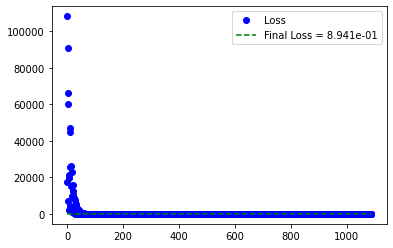

ReHfit: 9.55, Actual: 12.55, Error: 23.97%
ReEfit: -36.32, Actual: -52.55, Error: 30.90%
ReHTfit: 8.39, Actual: 6.97, Error: 20.25%
Chi-Squared Value for this fit: 6.982e-03
Chi-Squared Value for expected fit: 7.247e-03
MSE Loss Value for this fit: 8.941e-01
Average Error for set #1 using ANN = 25.04%
Average Error for set #1 using scipy = 1.18%
-
Training set #4


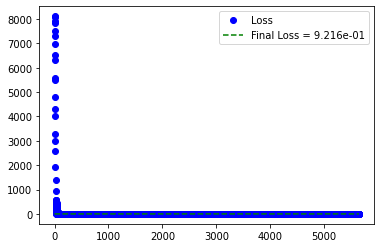

ReHfit: 10.00, Actual: 12.55, Error: 20.31%
ReEfit: -39.27, Actual: -52.55, Error: 25.27%
ReHTfit: 7.38, Actual: 6.97, Error: 5.87%
Chi-Squared Value for this fit: 2.848e-03
Chi-Squared Value for expected fit: 2.768e-03
MSE Loss Value for this fit: 9.216e-01
Average Error for set #4 using ANN = 17.15%
Average Error for set #4 using scipy = 4.84%
-
Training set #6


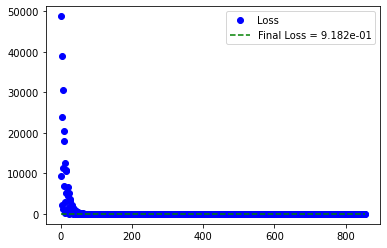

ReHfit: 7.02, Actual: 11.74, Error: 40.20%
ReEfit: -24.94, Actual: -51.74, Error: 51.79%
ReHTfit: 8.25, Actual: 6.52, Error: 26.51%
Chi-Squared Value for this fit: 4.462e-03
Chi-Squared Value for expected fit: 4.402e-03
MSE Loss Value for this fit: 9.182e-01
Average Error for set #6 using ANN = 39.50%
Average Error for set #6 using scipy = 7.93%
-
Training set #8


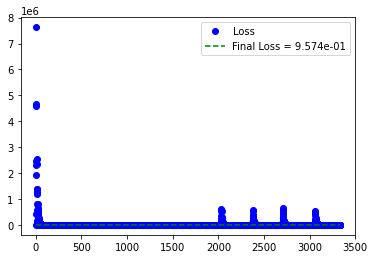

ReHfit: 10.35, Actual: 12.55, Error: 17.53%
ReEfit: -41.10, Actual: -52.55, Error: 21.79%
ReHTfit: 6.90, Actual: 6.97, Error: 1.04%
Chi-Squared Value for this fit: 1.856e-03
Chi-Squared Value for expected fit: 1.718e-03
MSE Loss Value for this fit: 9.574e-01
Average Error for set #8 using ANN = 13.45%
Average Error for set #8 using scipy = 5.51%
-
Training set #9


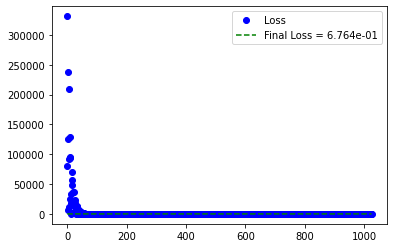

ReHfit: 7.37, Actual: 6.99, Error: 5.45%
ReEfit: -49.10, Actual: -46.99, Error: 4.49%
ReHTfit: 3.02, Actual: 3.88, Error: 22.15%
Chi-Squared Value for this fit: 2.410e-03
Chi-Squared Value for expected fit: 2.861e-03
MSE Loss Value for this fit: 6.764e-01
Average Error for set #9 using ANN = 10.69%
Average Error for set #9 using scipy = 15.53%
-
Training set #11


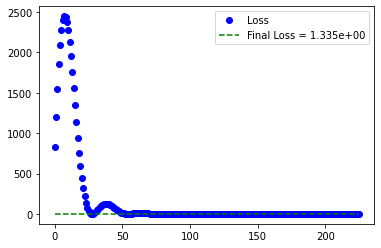

ReHfit: 2.12, Actual: 11.74, Error: 81.95%
ReEfit: 1.91, Actual: -51.74, Error: 103.69%
ReHTfit: 8.13, Actual: 6.52, Error: 24.63%
Chi-Squared Value for this fit: 3.699e-03
Chi-Squared Value for expected fit: 2.379e-03
MSE Loss Value for this fit: 1.335e+00
Average Error for set #11 using ANN = 70.09%
Average Error for set #11 using scipy = 5.96%
-

Avg. Error of ReH = 24.29%
Variance in Error of ReH = 403.90

Avg. Error of ReE = 30.02%
Variance in Error of ReE = 674.13

Avg. Error of ReHT = 13.52%
Variance in Error of ReHT = 80.91


In [10]:
for datset in bads:
    print('Training set #' + str(datset))
    a = datset*36
    b = a + 36


    xdat = np.asarray([phi[a:b], qq[a:b], xb[a:b], t[a:b], k[a:b], F1[a:b], F2[a:b], const[a:b]])
    x = Variable(torch.from_numpy(xdat[1:5].transpose()))
    y = Variable(torch.from_numpy(ydat[a:b].transpose()))
    xdat = Variable(torch.from_numpy(xdat))
    errs = Variable(torch.from_numpy(errF[a:b]))

    net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 70),
        torch.nn.Sigmoid(),
        torch.nn.Linear(70, 3)
    )
    
    optimizer = torch.optim.Adam(net.parameters(), lr=5)
    
    losses = []
    losses.clear()
    
    loss2 = -20
    loss1 = -10
    while abs(loss2 - loss1) > 0.001:

        p = net(x.float()) #output 3 predicted values for cffs

        ReHfit = torch.mean(torch.transpose(p, 0, 1)[0])
        ReEfit = torch.mean(torch.transpose(p, 0, 1)[1])
        ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2])
        cffs = [ReHfit, ReEfit, ReHTfit]
    
        loss = loss_func(xdat.float(), cffs, errs, y)
        losses.append(float(loss.data.float()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if loss remains within 0.001 for 10 epochs, end loop
        if EPOCH%10 == 0:
            loss2 = loss1
            loss1 = float(loss.data.float())
        
        EPOCH+=1

    plt.plot(np.linspace(0, len(losses)-5, len(losses)-5), np.asarray(losses[5:]), 'bo', label='Loss')
    plt.plot(np.linspace(0, len(losses)-5, len(losses)-5), np.zeros(len(losses)-5)+float(loss.data.float()), 'g--', label='Final Loss = %.3e' % (float(loss.data.float())))
    plt.legend()
    plt.show()

    ReHfit = ReHfit.data.numpy()
    ReEfit = ReEfit.data.numpy()
    ReHTfit = ReHTfit.data.numpy()
    fit_cffs = [ReHfit, ReEfit, ReHTfit]

#     plt.plot(phi[a:b], ydat[a:b], 'bo', label='data')
#     plt.plot(phi[a:b], f(xdat,fit_cffs), 'g--', label='fit')
#     plt.legend()
#     plt.show()

    err_H.append(abs(100*(abs(ReHfit-ReH_target[a]))/ReH_target[a]))
    err_E.append(abs(100*(abs(ReEfit-ReE_target[a]))/ReE_target[a]))
    err_HT.append(abs(100*(abs(ReHTfit-ReHT_target[a]))/ReHT_target[a]))
    
    print('ReHfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReHfit, ReH_target[a], abs(100*(abs(ReHfit-ReH_target[a]))/ReH_target[a])))
    print('ReEfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReEfit, ReE_target[a], abs(100*(abs(ReEfit-ReE_target[a]))/ReE_target[a])))
    print('ReHTfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReHTfit, ReHT_target[a], abs(100*(abs(ReHTfit-ReHT_target[a]))/ReHT_target[a])))

    print('Chi-Squared Value for this fit: %.3e' % (chisquare(f(xdat,fit_cffs), ydat[a:b])[0]))
    print('Chi-Squared Value for expected fit: %.3e' % (chisquare(f(xdat,[ReH_target[a], ReE_target[a], ReHT_target[a]]), ydat[a:b])[0]))
    print('MSE Loss Value for this fit: %.3e' % (float(loss.data.float())))
    print('Average Error for set #%d using ANN = %.2f%%' % ((datset), ((err_H[-1]+err_E[-1]+err_HT[-1])/3)))
    dvcsfit.fit_scipy(datset)
    print('-')

print('\n\033[1m%s%.2f%%' % ('Avg. Error of ReH = ', sum(err_H)/len(err_H)))
print('\033[1m%s%.2f\n' % ('Variance in Error of ReH = ', np.var(err_H)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReE = ', sum(err_E)/len(err_E)))
print('\033[1m%s%.2f\n' % ('Variance in Error of ReE = ', np.var(err_E)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReHT = ', sum(err_HT)/len(err_HT)))
print('\033[1m%s%.2f' % ('Variance in Error of ReHT = ', np.var(err_HT)))